# Task 1: Preprocess and Explore the Data

**GMF Time Series Forecasting Challenge**

This notebook covers:
- Loading and cleaning ALL available financial data
- Comprehensive Exploratory Data Analysis (EDA)
- Stationarity testing for all assets
- Volatility analysis across sectors
- Risk metrics calculation for all assets
- Analyst ratings analysis
- Complete data utilization summary

## 1. Import Libraries and Setup

In [36]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Financial libraries
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load ALL Available Data Files

In [37]:
# Load ALL YFinance data files
stock_files = {
    'TSLA': '../data/raw/yfinance_data/TSLA_historical_data.csv',
    'AAPL': '../data/raw/yfinance_data/AAPL_historical_data.csv',
    'AMZN': '../data/raw/yfinance_data/AMZN_historical_data.csv',
    'GOOG': '../data/raw/yfinance_data/GOOG_historical_data.csv',
    'META': '../data/raw/yfinance_data/META_historical_data.csv',
    'MSFT': '../data/raw/yfinance_data/MSFT_historical_data.csv',
    'NVDA': '../data/raw/yfinance_data/NVDA_historical_data.csv'
}

# Load analyst ratings data
analyst_data = pd.read_csv('../data/raw/raw_analyst_ratings.csv')
print(f"Analyst ratings data: {len(analyst_data):,} records")

# Load all stock data
all_stocks = {}
for ticker, file_path in stock_files.items():
    try:
        data = pd.read_csv(file_path)
        print(f"{ticker}: {data.shape[0]} rows")
        all_stocks[ticker] = data
    except Exception as e:
        print(f"Error loading {ticker}: {e}")

print(f"\n✅ Loaded {len(all_stocks)} stock datasets")

Analyst ratings data: 1,407,328 records
TSLA: 3545 rows
AAPL: 10998 rows
AMZN: 6846 rows
GOOG: 5020 rows
META: 2926 rows
MSFT: 9672 rows
NVDA: 6421 rows

✅ Loaded 7 stock datasets


## 3. Data Cleaning and Preprocessing

In [38]:
# Clean stock data function
def clean_stock_data(df, ticker):
    """Clean stock data"""
    # Convert date column
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # Ensure timezone-naive index for consistency
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    
    # Filter to required period (July 1, 2015 to July 31, 2025)
    start_date = '2015-07-01'
    end_date = '2025-07-31'
    df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"{ticker} missing values:\n{missing_values}")
    
    # Remove any rows with missing values
    df = df.dropna()
    
    return df

# Clean all stock data
cleaned_stocks = {}
for ticker, data in all_stocks.items():
    cleaned_data = clean_stock_data(data, ticker)
    cleaned_stocks[ticker] = cleaned_data
    print(f"{ticker}: {cleaned_data.shape[0]} rows, {cleaned_data.index.min()} to {cleaned_data.index.max()}")

print(f"\n✅ Cleaned {len(cleaned_stocks)} stock datasets")

TSLA: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
AAPL: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
AMZN: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
GOOG: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
META: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
MSFT: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00
NVDA: 2285 rows, 2015-07-01 00:00:00 to 2024-07-30 00:00:00

✅ Cleaned 7 stock datasets


## 4. Fetch SPY and BND Data (Required Assets)

In [39]:
# Fetch SPY and BND data using YFinance
def fetch_stock_data(ticker, start_date, end_date):
    """Fetch stock data from YFinance"""
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    # Ensure timezone-naive index for consistency
    if data.index.tz is not None:
        data.index = data.index.tz_localize(None)
    return data

# Fetch SPY and BND data
start_date = '2015-07-01'
end_date = '2025-07-31'

spy_data = fetch_stock_data('SPY', start_date, end_date)
bnd_data = fetch_stock_data('BND', start_date, end_date)

print(f"SPY data shape: {spy_data.shape}")
print(f"BND data shape: {bnd_data.shape}")
print(f"\nSPY date range: {spy_data.index.min()} to {spy_data.index.max()}")
print(f"BND date range: {bnd_data.index.min()} to {bnd_data.index.max()}")

# Add to cleaned stocks
cleaned_stocks['SPY'] = spy_data
cleaned_stocks['BND'] = bnd_data

print(f"\n✅ Total assets: {len(cleaned_stocks)} (TSLA, AAPL, AMZN, GOOG, META, MSFT, NVDA, SPY, BND)")

SPY data shape: (2535, 8)
BND data shape: (2535, 8)

SPY date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
BND date range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00

✅ Total assets: 9 (TSLA, AAPL, AMZN, GOOG, META, MSFT, NVDA, SPY, BND)


## 5. Basic Statistics and Data Understanding

In [40]:
# Basic statistics for all stocks
print("Basic Statistics for All Assets:")
print("="*60)

for ticker, data in cleaned_stocks.items():
    print(f"\n{ticker} Statistics:")
    print(f"  Shape: {data.shape}")
    print(f"  Date range: {data.index.min()} to {data.index.max()}")
    print(f"  Close price range: ${data['Close'].min():.2f} to ${data['Close'].max():.2f}")
    print(f"  Volume range: {data['Volume'].min():,.0f} to {data['Volume'].max():,.0f}")
    
    # Check for outliers using IQR method
    Q1 = data['Close'].quantile(0.25)
    Q3 = data['Close'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data['Close'] < Q1 - 1.5 * IQR) | (data['Close'] > Q3 + 1.5 * IQR)]
    print(f"  Outliers: {len(outliers)} rows ({len(outliers)/len(data)*100:.1f}%)")

print(f"\n✅ Analyzed {len(cleaned_stocks)} assets")

Basic Statistics for All Assets:

TSLA Statistics:
  Shape: (2285, 8)
  Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
  Close price range: $9.58 to $409.97
  Volume range: 10,620,000 to 914,082,000
  Outliers: 0 rows (0.0%)

AAPL Statistics:
  Shape: (2285, 8)
  Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
  Close price range: $22.58 to $234.82
  Volume range: 24,048,300 to 648,825,200
  Outliers: 0 rows (0.0%)

AMZN Statistics:
  Shape: (2285, 8)
  Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
  Close price range: $21.49 to $200.00
  Volume range: 17,626,000 to 438,188,000
  Outliers: 0 rows (0.0%)

GOOG Statistics:
  Shape: (2285, 8)
  Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
  Close price range: $25.84 to $192.66
  Volume range: 6,936,000 to 223,298,000
  Outliers: 0 rows (0.0%)

META Statistics:
  Shape: (2285, 8)
  Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
  Close price range: $82.09 to $539.91
  Volume range: 5,467,500 to 232

## 6. Exploratory Data Analysis (EDA)

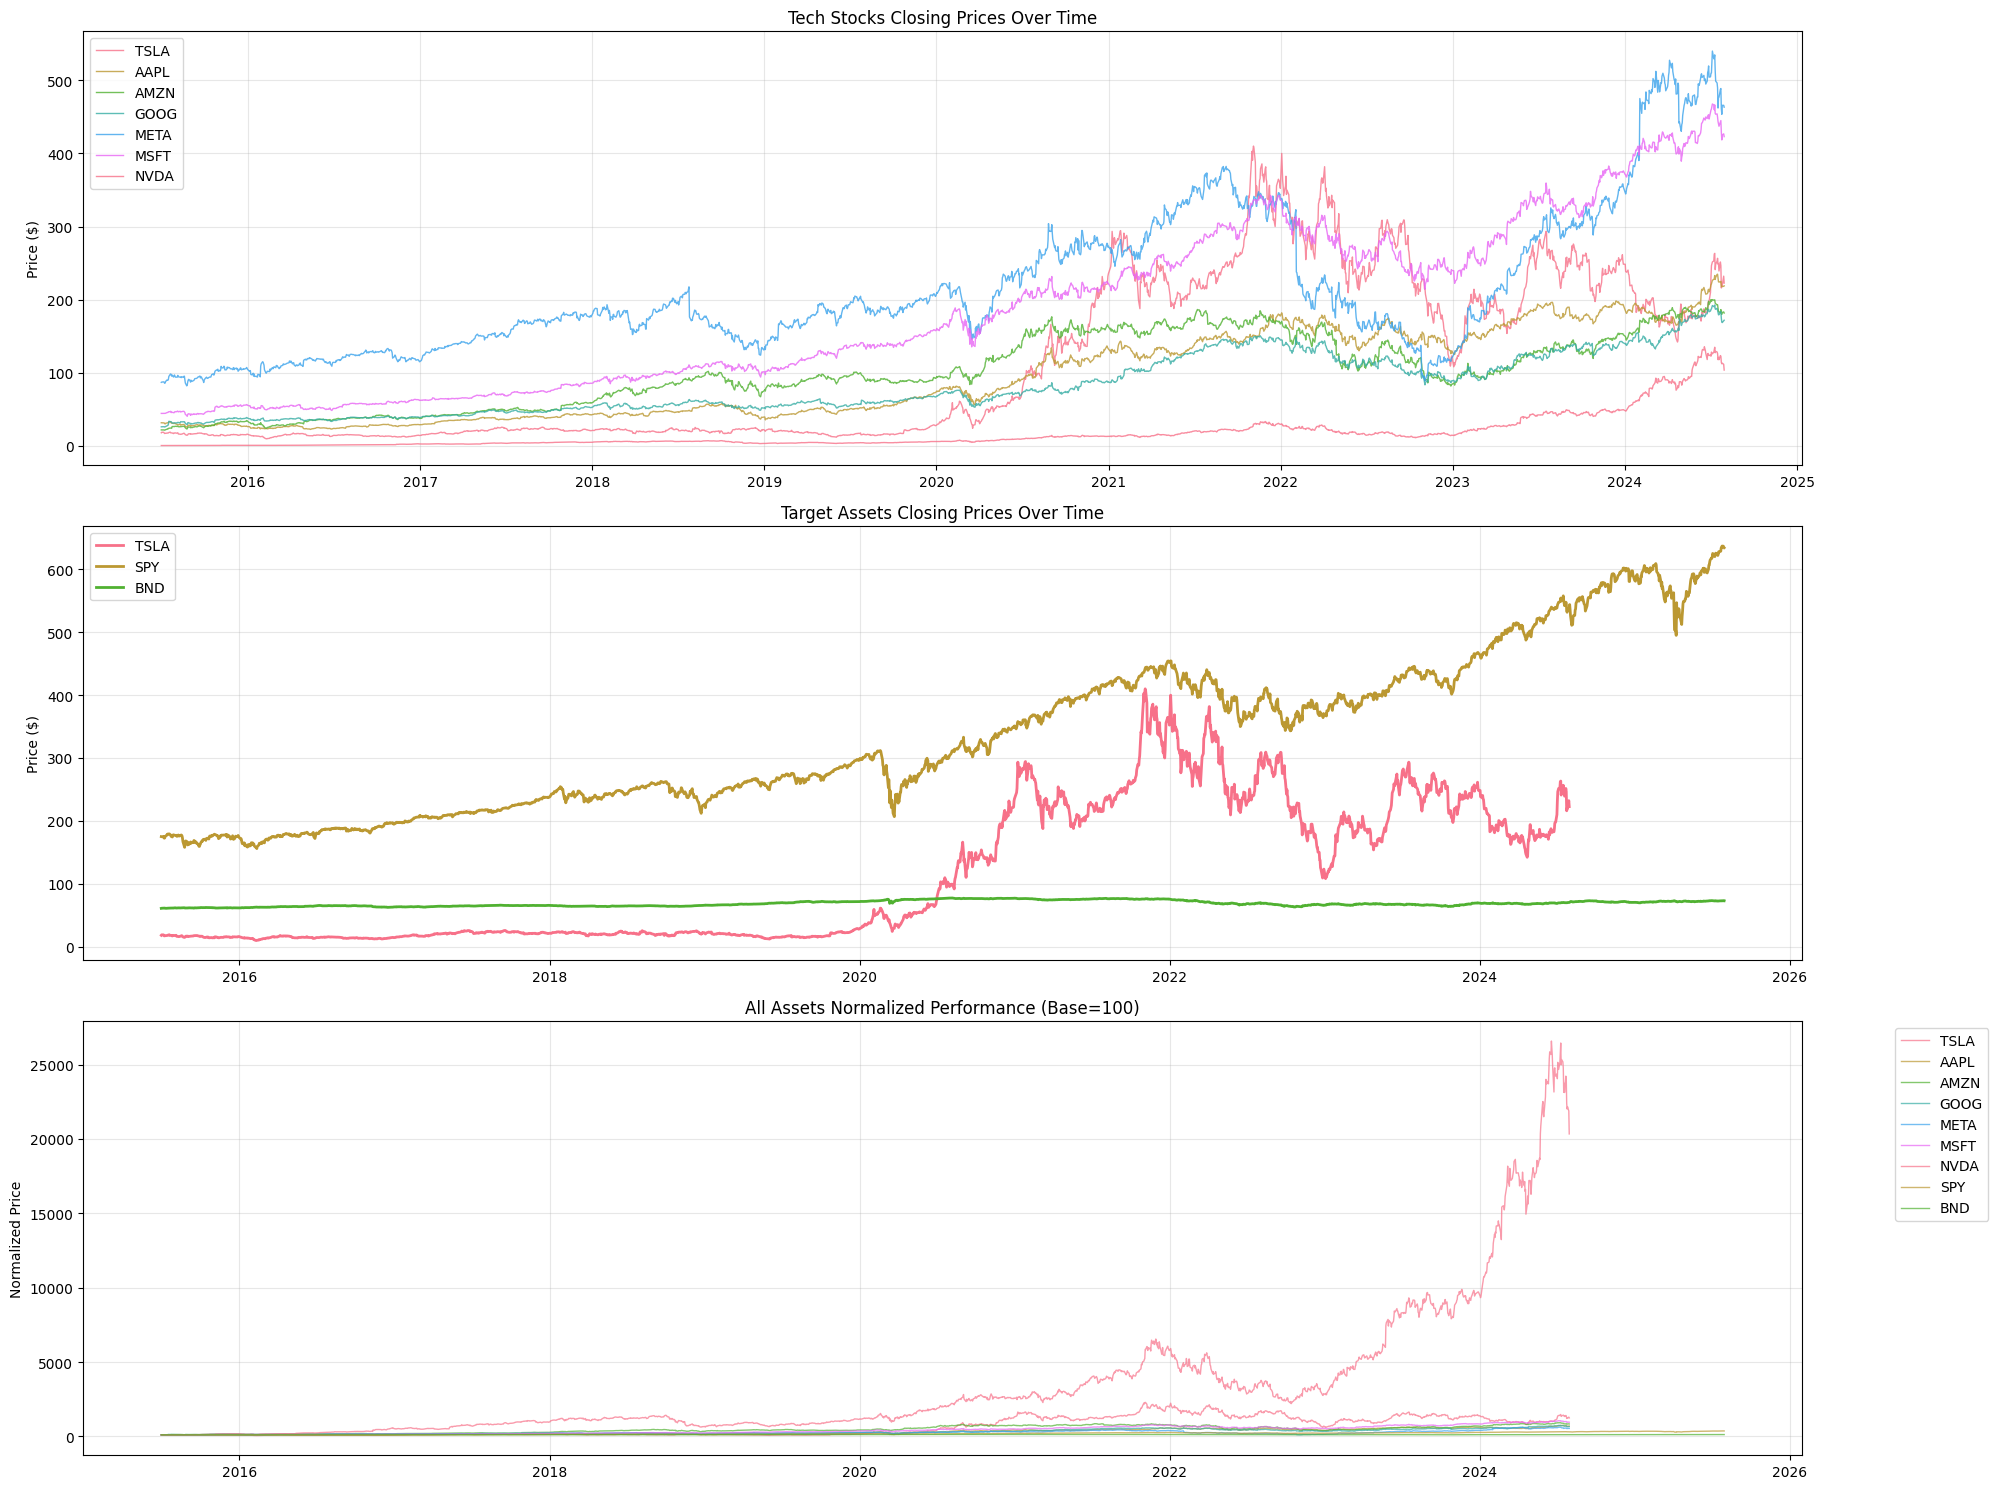

In [41]:
# Plot closing prices for all assets
plt.figure(figsize=(20, 15))

# Tech stocks
tech_stocks = ['TSLA', 'AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
plt.subplot(3, 1, 1)
for ticker in tech_stocks:
    if ticker in cleaned_stocks:
        plt.plot(cleaned_stocks[ticker].index, cleaned_stocks[ticker]['Close'], 
                label=ticker, alpha=0.8, linewidth=1)
plt.title('Tech Stocks Closing Prices Over Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Target assets
target_assets = ['TSLA', 'SPY', 'BND']
plt.subplot(3, 1, 2)
for ticker in target_assets:
    if ticker in cleaned_stocks:
        plt.plot(cleaned_stocks[ticker].index, cleaned_stocks[ticker]['Close'], 
                label=ticker, linewidth=2)
plt.title('Target Assets Closing Prices Over Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# All assets normalized
plt.subplot(3, 1, 3)
for ticker, data in cleaned_stocks.items():
    normalized = data['Close'] / data['Close'].iloc[0] * 100
    plt.plot(data.index, normalized, label=ticker, alpha=0.7, linewidth=1)
plt.title('All Assets Normalized Performance (Base=100)')
plt.ylabel('Normalized Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Calculate Daily Returns for All Assets

TSLA: 2284 return observations
AAPL: 2284 return observations
AMZN: 2284 return observations
GOOG: 2284 return observations
META: 2284 return observations
MSFT: 2284 return observations
NVDA: 2284 return observations
SPY: 2534 return observations
BND: 2534 return observations

Comprehensive returns DataFrame shape: (2534, 9)


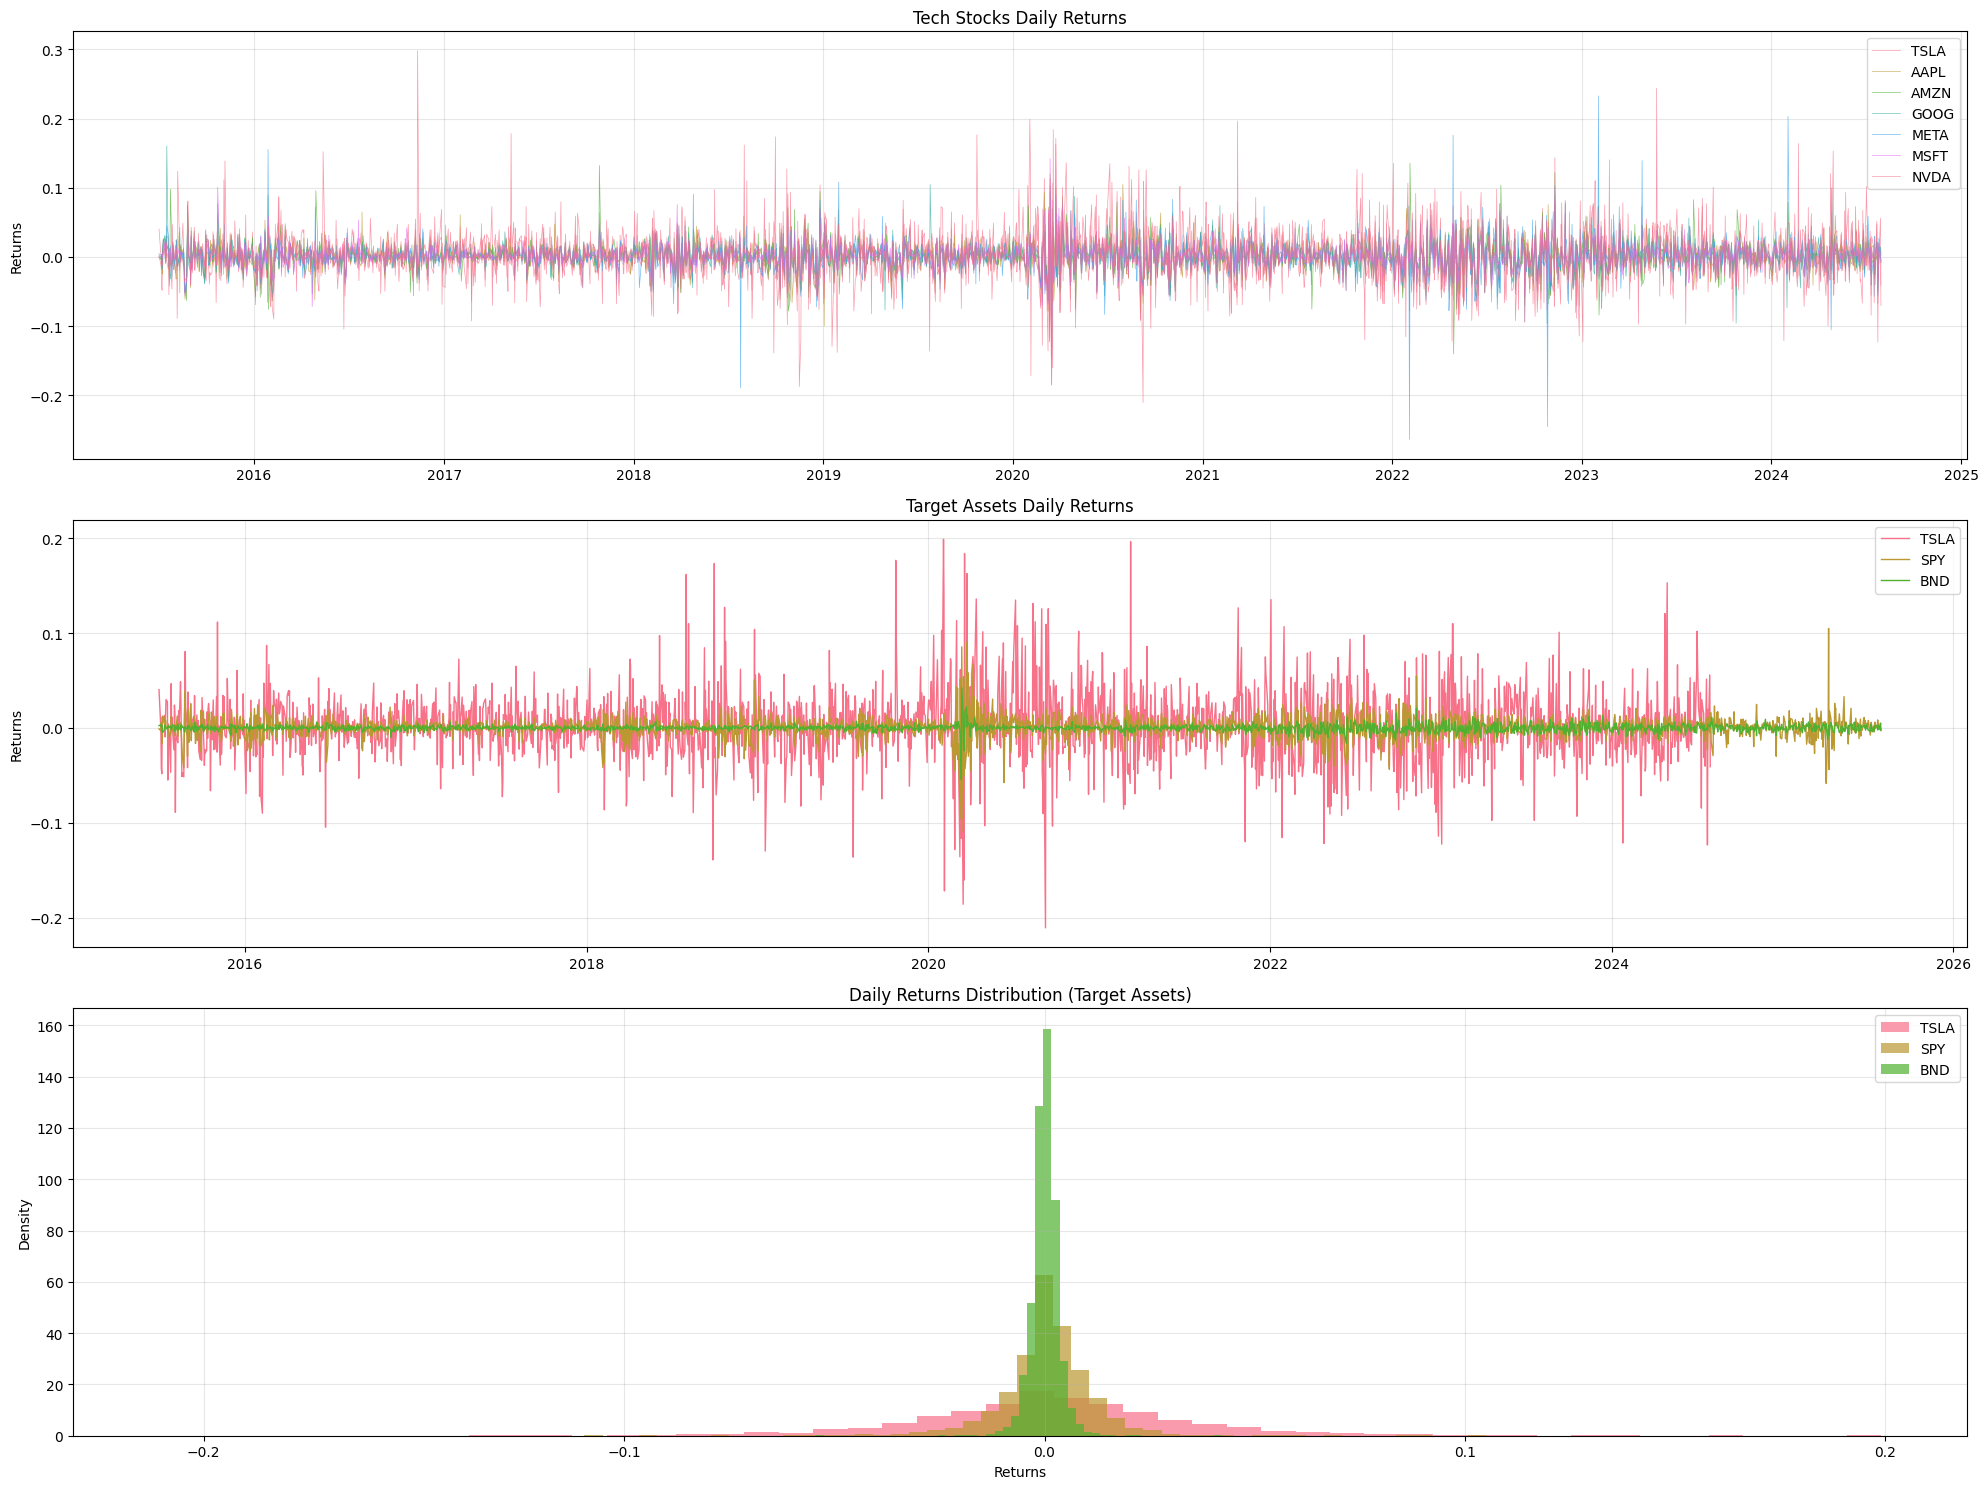

In [42]:
# Calculate daily returns for all assets
all_returns = {}

for ticker, data in cleaned_stocks.items():
    returns = data['Close'].pct_change().dropna()
    # Ensure timezone-naive index for consistency
    if returns.index.tz is not None:
        returns.index = returns.index.tz_localize(None)
    all_returns[ticker] = returns
    print(f"{ticker}: {len(returns)} return observations")

# Create comprehensive returns DataFrame
all_returns_df = pd.DataFrame(all_returns)
print(f"\nComprehensive returns DataFrame shape: {all_returns_df.shape}")

# Plot daily returns
plt.figure(figsize=(20, 15))

# Tech stocks returns
plt.subplot(3, 1, 1)
for ticker in tech_stocks:
    if ticker in all_returns:
        plt.plot(all_returns[ticker].index, all_returns[ticker].values, 
                alpha=0.7, linewidth=0.5, label=ticker)
plt.title('Tech Stocks Daily Returns')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Target assets returns
plt.subplot(3, 1, 2)
for ticker in target_assets:
    if ticker in all_returns:
        plt.plot(all_returns[ticker].index, all_returns[ticker].values, 
                linewidth=1, label=ticker)
plt.title('Target Assets Daily Returns')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Returns distribution
plt.subplot(3, 1, 3)
for ticker in target_assets:
    if ticker in all_returns:
        plt.hist(all_returns[ticker].values, bins=50, alpha=0.7, 
                label=ticker, density=True)
plt.title('Daily Returns Distribution (Target Assets)')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Volatility Analysis

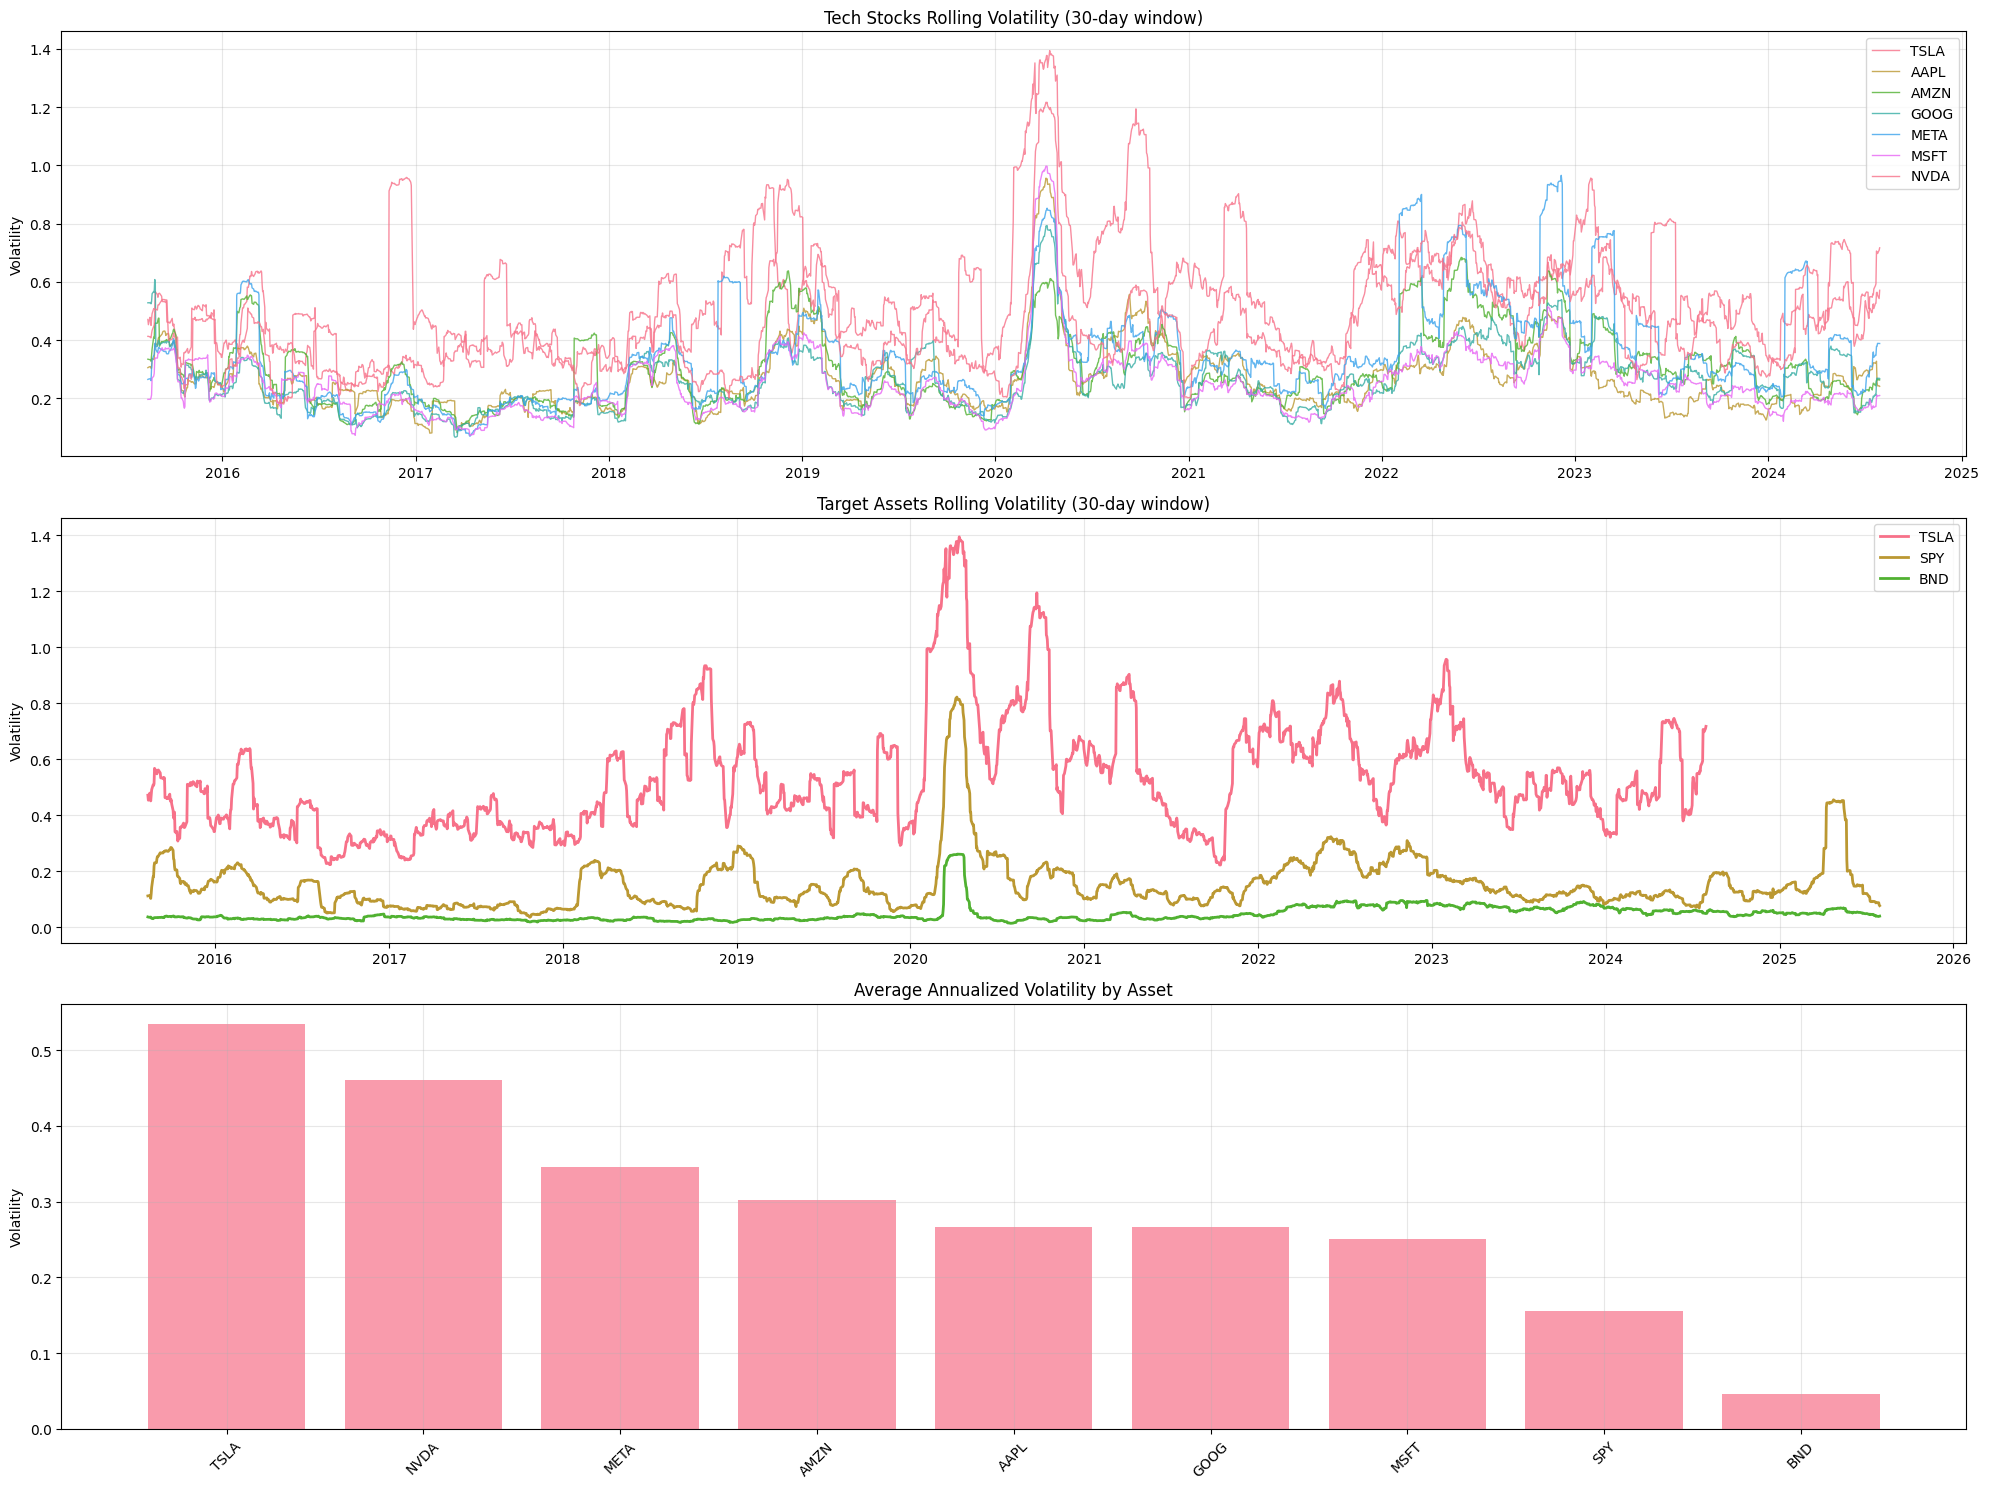


Average Annualized Volatility (2015-2025):
TSLA: 53.45%
NVDA: 46.05%
META: 34.60%
AMZN: 30.24%
AAPL: 26.69%
GOOG: 26.63%
MSFT: 25.01%
SPY: 15.49%
BND: 4.62%


In [43]:
# Calculate rolling volatility for all assets
def calculate_rolling_volatility(returns, window=30):
    """Calculate rolling volatility"""
    return returns.rolling(window=window).std() * np.sqrt(252)  # Annualized

all_volatility = {}
for ticker, returns in all_returns.items():
    volatility = calculate_rolling_volatility(returns)
    all_volatility[ticker] = volatility

# Create volatility DataFrame
all_volatility_df = pd.DataFrame(all_volatility)

# Plot volatility comparison
plt.figure(figsize=(20, 15))

# Tech stocks volatility
plt.subplot(3, 1, 1)
for ticker in tech_stocks:
    if ticker in all_volatility_df.columns:
        plt.plot(all_volatility_df.index, all_volatility_df[ticker], 
                label=ticker, alpha=0.8, linewidth=1)
plt.title('Tech Stocks Rolling Volatility (30-day window)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Target assets volatility
plt.subplot(3, 1, 2)
for ticker in target_assets:
    if ticker in all_volatility_df.columns:
        plt.plot(all_volatility_df.index, all_volatility_df[ticker], 
                label=ticker, linewidth=2)
plt.title('Target Assets Rolling Volatility (30-day window)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Average volatilities
plt.subplot(3, 1, 3)
avg_vol = all_volatility_df.mean().sort_values(ascending=False)
plt.bar(avg_vol.index, avg_vol.values, alpha=0.7)
plt.title('Average Annualized Volatility by Asset')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print average volatilities
print("\nAverage Annualized Volatility (2015-2025):")
for ticker, vol in avg_vol.items():
    print(f"{ticker}: {vol:.2%}")

## 9. Stationarity Testing

In [44]:
# Augmented Dickey-Fuller test for stationarity
def test_stationarity(timeseries, name):
    """Perform ADF test for stationarity"""
    print(f"\nADF Test for {name}:")
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\nResult: Stationary (reject null hypothesis)")
    else:
        print("\nResult: Non-stationary (fail to reject null hypothesis)")
    
    return result

# Test stationarity of closing prices and returns for target assets
print("Testing stationarity of closing prices:")
for ticker in target_assets:
    if ticker in cleaned_stocks:
        test_stationarity(cleaned_stocks[ticker]['Close'], f'{ticker} Closing Price')

print("\n" + "="*50)
print("Testing stationarity of daily returns:")
for ticker in target_assets:
    if ticker in all_returns:
        test_stationarity(all_returns[ticker], f'{ticker} Daily Returns')

Testing stationarity of closing prices:

ADF Test for TSLA Closing Price:
ADF Statistic: -1.289254
p-value: 0.634074
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: Non-stationary (fail to reject null hypothesis)

ADF Test for SPY Closing Price:
ADF Statistic: 0.690813
p-value: 0.989653
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: Non-stationary (fail to reject null hypothesis)

ADF Test for BND Closing Price:
ADF Statistic: -1.536249
p-value: 0.515510
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: Non-stationary (fail to reject null hypothesis)

Testing stationarity of daily returns:

ADF Test for TSLA Daily Returns:
ADF Statistic: -47.829796
p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: Stationary (reject null hypothesis)

ADF Test for SPY Daily Returns:
ADF Statistic: -16.264376
p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: Stationary (reject null hypothesis)

ADF T

## 10. Risk Metrics Calculation

In [45]:
# Calculate comprehensive risk metrics for all assets
def calculate_risk_metrics(returns, name):
    """Calculate key risk metrics"""
    # Annualized metrics
    annual_return = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0
    
    # Value at Risk (95% and 99% confidence)
    var_95 = np.percentile(returns, 5)
    var_99 = np.percentile(returns, 1)
    
    # Maximum drawdown
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Skewness and kurtosis
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'var_95': var_95,
        'var_99': var_99,
        'max_drawdown': max_drawdown,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

# Calculate risk metrics for all assets
all_risk_metrics = {}
for ticker, returns in all_returns.items():
    metrics = calculate_risk_metrics(returns, ticker)
    all_risk_metrics[ticker] = metrics
    
    print(f"\nRisk Metrics for {ticker}:")
    print(f"  Annual Return: {metrics['annual_return']:.4f} ({metrics['annual_return']*100:.2f}%)")
    print(f"  Annual Volatility: {metrics['annual_volatility']:.4f} ({metrics['annual_volatility']*100:.2f}%)")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
    print(f"  VaR (95%): {metrics['var_95']:.4f} ({metrics['var_95']*100:.2f}%)")
    print(f"  VaR (99%): {metrics['var_99']:.4f} ({metrics['var_99']*100:.2f}%)")
    print(f"  Maximum Drawdown: {metrics['max_drawdown']:.4f} ({metrics['max_drawdown']*100:.2f}%)")
    print(f"  Skewness: {metrics['skewness']:.4f}")
    print(f"  Kurtosis: {metrics['kurtosis']:.4f}")

# Create comprehensive risk table
risk_df = pd.DataFrame(all_risk_metrics).T
print("\n" + "="*80)
print("COMPREHENSIVE RISK METRICS FOR ALL ASSETS")
print("="*80)
print(risk_df.round(4))


Risk Metrics for TSLA:
  Annual Return: 0.4432 (44.32%)
  Annual Volatility: 0.5754 (57.54%)
  Sharpe Ratio: 0.7701
  VaR (95%): -0.0525 (-5.25%)
  VaR (99%): -0.0923 (-9.23%)
  Maximum Drawdown: -0.7363 (-73.63%)
  Skewness: 0.1897
  Kurtosis: 4.1007

Risk Metrics for AAPL:
  Annual Return: 0.2557 (25.57%)
  Annual Volatility: 0.2908 (29.08%)
  Sharpe Ratio: 0.8793
  VaR (95%): -0.0278 (-2.78%)
  VaR (99%): -0.0482 (-4.82%)
  Maximum Drawdown: -0.3873 (-38.73%)
  Skewness: 0.0051
  Kurtosis: 5.2703

Risk Metrics for AMZN:
  Annual Return: 0.2871 (28.71%)
  Annual Volatility: 0.3272 (32.72%)
  Sharpe Ratio: 0.8775
  VaR (95%): -0.0315 (-3.15%)
  VaR (99%): -0.0560 (-5.60%)
  Maximum Drawdown: -0.5615 (-56.15%)
  Skewness: 0.2214
  Kurtosis: 5.1322

Risk Metrics for GOOG:
  Annual Return: 0.2498 (24.98%)
  Annual Volatility: 0.2895 (28.95%)
  Sharpe Ratio: 0.8630
  VaR (95%): -0.0276 (-2.76%)
  VaR (99%): -0.0501 (-5.01%)
  Maximum Drawdown: -0.4460 (-44.60%)
  Skewness: 0.2680
  Kurto

## 11. Correlation Analysis

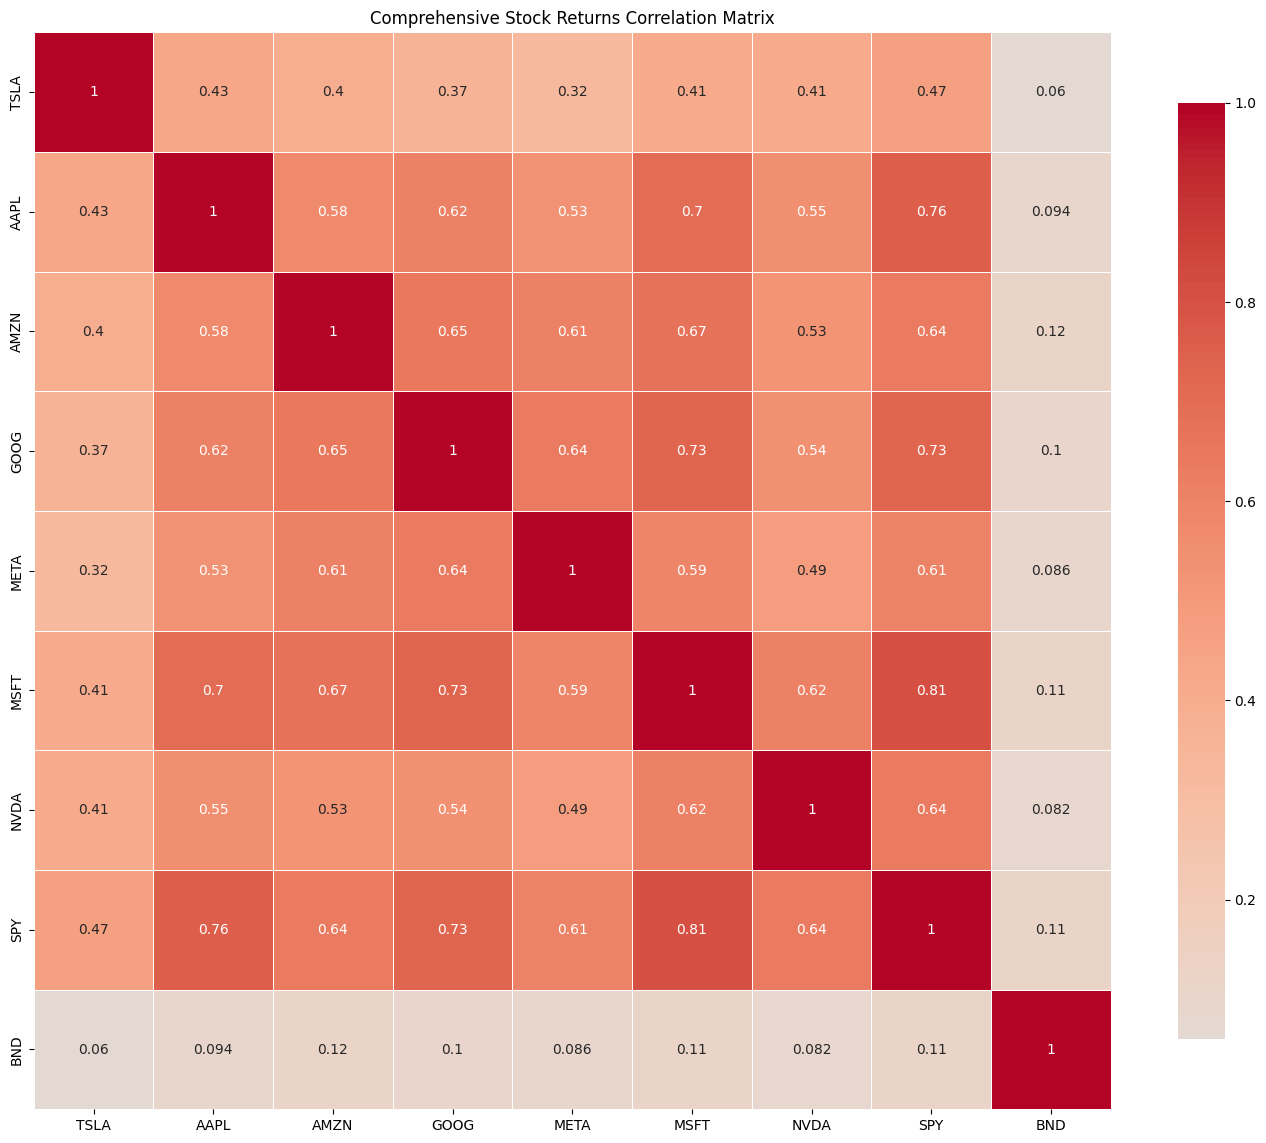


Correlations with TSLA:
TSLA    1.000000
SPY     0.466431
AAPL    0.434268
MSFT    0.411368
NVDA    0.409911
AMZN    0.395163
GOOG    0.365576
META    0.324371
BND     0.060361
Name: TSLA, dtype: float64

Correlations with SPY:
SPY     1.000000
MSFT    0.807673
AAPL    0.756026
GOOG    0.725828
AMZN    0.637239
NVDA    0.637020
META    0.606086
TSLA    0.466431
BND     0.114846
Name: SPY, dtype: float64

Correlations with BND:
BND     1.000000
AMZN    0.115942
SPY     0.114846
MSFT    0.114648
GOOG    0.101636
AAPL    0.094111
META    0.086134
NVDA    0.082002
TSLA    0.060361
Name: BND, dtype: float64


In [46]:
# Calculate correlation matrix for all assets
correlation_matrix = all_returns_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Comprehensive Stock Returns Correlation Matrix')
plt.tight_layout()
plt.show()

# Analyze correlations with target assets
print("\nCorrelations with TSLA:")
tsla_corr = correlation_matrix['TSLA'].sort_values(ascending=False)
print(tsla_corr)

print("\nCorrelations with SPY:")
spy_corr = correlation_matrix['SPY'].sort_values(ascending=False)
print(spy_corr)

print("\nCorrelations with BND:")
bnd_corr = correlation_matrix['BND'].sort_values(ascending=False)
print(bnd_corr)

## 12. Risk-Return Analysis

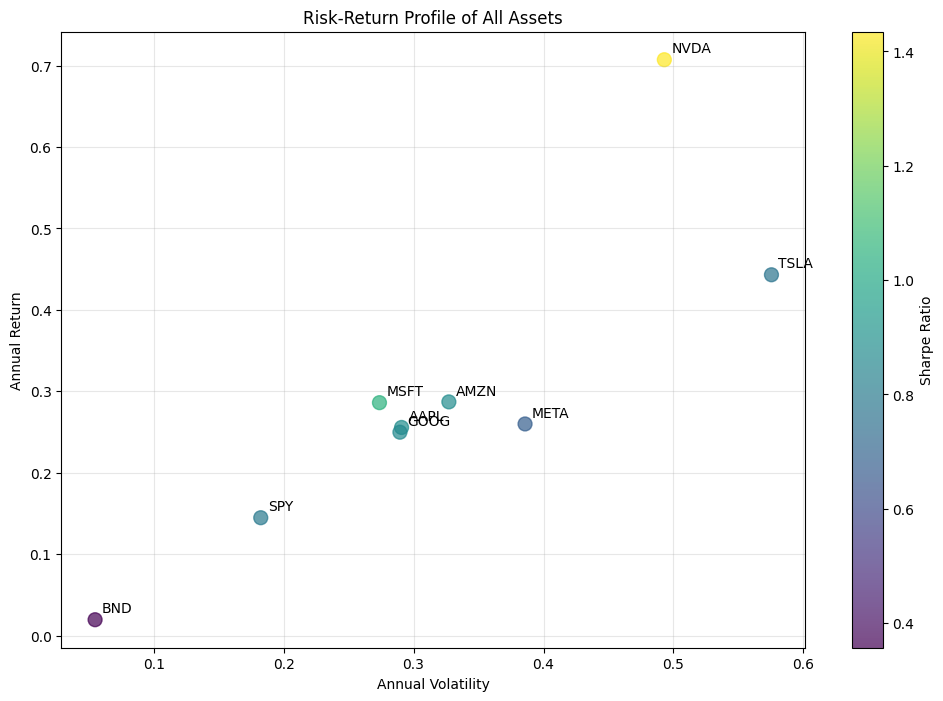


Top 5 Assets by Sharpe Ratio:
NVDA: 1.4346
MSFT: 1.0451
AAPL: 0.8793
AMZN: 0.8775
GOOG: 0.8630

Top 5 Assets by Annual Return:
NVDA: 0.7072 (70.72%)
TSLA: 0.4432 (44.32%)
AMZN: 0.2871 (28.71%)
MSFT: 0.2861 (28.61%)
META: 0.2600 (26.00%)


In [47]:
# Plot risk-return scatter for all assets
plt.figure(figsize=(12, 8))
plt.scatter(risk_df['annual_volatility'], risk_df['annual_return'], 
           s=100, alpha=0.7, c=risk_df['sharpe_ratio'], cmap='viridis')

for ticker in risk_df.index:
    plt.annotate(ticker, (risk_df.loc[ticker, 'annual_volatility'], 
                          risk_df.loc[ticker, 'annual_return']), 
                 xytext=(5, 5), textcoords='offset points')

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Risk-Return Profile of All Assets')
plt.grid(True, alpha=0.3)
plt.show()

# Print top performers
print("\nTop 5 Assets by Sharpe Ratio:")
top_sharpe = risk_df['sharpe_ratio'].sort_values(ascending=False).head(5)
for ticker, sharpe in top_sharpe.items():
    print(f"{ticker}: {sharpe:.4f}")

print("\nTop 5 Assets by Annual Return:")
top_return = risk_df['annual_return'].sort_values(ascending=False).head(5)
for ticker, ret in top_return.items():
    print(f"{ticker}: {ret:.4f} ({ret*100:.2f}%)")

## 13. Analyst Ratings Analysis

Enhanced Analyst Ratings Analysis:
Cleaned analyst data: 732,239 records after date filtering

TSLA Analysis:
  Total mentions: 123 headlines
  Date range: 2015-12-29 00:00:00 to 2020-06-09 12:22:38
  Publishers: 10 unique sources
  Sample headlines:
    - UBS Says 5 Most Shorted Stocks On Monday Were TSLA, CAT, NFLX, AA, & BABA Accord...
    - Benzinga Pro's Top 5 Stocks To Watch For Tues., Dec. 24, 2019: TSLA, WCC, ACST, ...
    - Benzinga Pro's Top 5 Stocks To Watch For Fri., Feb. 14, 2020: TSLA, ROKU, CRON, ...

SPY Analysis:
  Total mentions: 2647 headlines
  Date range: 2015-08-12 00:00:00 to 2020-05-04 00:00:00
  Publishers: 25 unique sources
  Sample headlines:
    - Benzinga Pro's Top 5 Stocks To Watch For Mon., Mar. 16, 2020: SPY, AAL, ZM, LVS,...
    - Shares of several technology stocks are trading lower potentially on profit taki...
    - Mid-Morning Market Update: Markets Mostly Flat; Krispy Kreme Misses Q2 Estimates...

BND Analysis:
  Total mentions: 3 headlines
  Date 

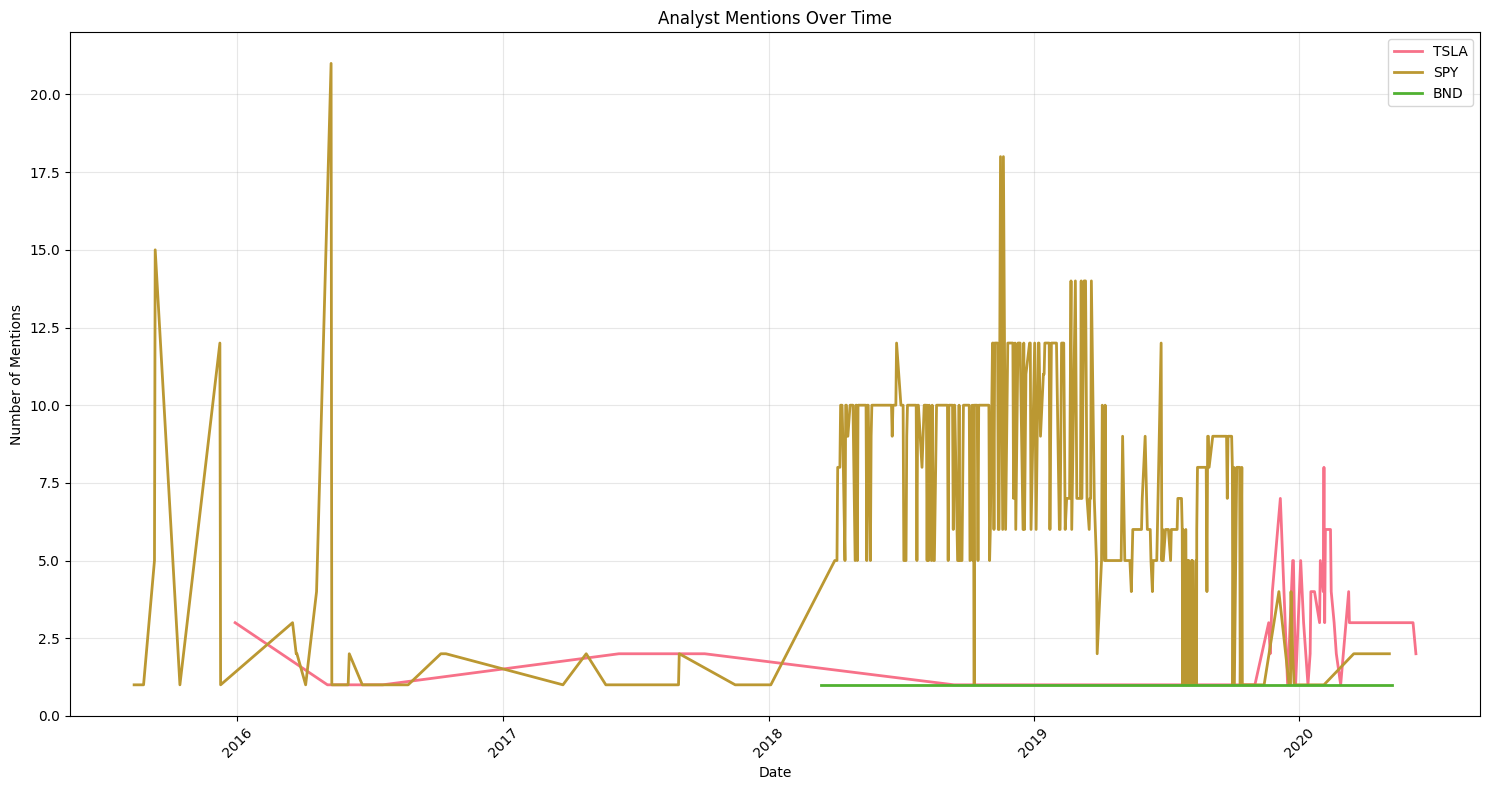

In [48]:
# Enhanced analyst ratings analysis
print("Enhanced Analyst Ratings Analysis:")
print("="*50)

# Clean analyst data with robust datetime parsing
try:
    # Use UTC=True to handle mixed timezones and silence future warning
    analyst_data['date'] = pd.to_datetime(analyst_data['date'], format='mixed', errors='coerce', utc=True)
    # Convert to timezone-naive for consistency with other data
    analyst_data['date'] = analyst_data['date'].dt.tz_localize(None)
except (ValueError, TypeError):
    # Fallback to default parsing
    analyst_data['date'] = pd.to_datetime(analyst_data['date'], errors='coerce')

# Remove rows with invalid dates
analyst_data = analyst_data.dropna(subset=['date'])
analyst_data = analyst_data[analyst_data['date'] >= '2015-07-01']

print(f"Cleaned analyst data: {len(analyst_data):,} records after date filtering")

# Analyze mentions for target stocks
target_stocks = ['TSLA', 'SPY', 'BND']
stock_mentions = {}

for stock in target_stocks:
    # Find mentions in headlines (handle NaN values)
    if 'headline' in analyst_data.columns:
        mentions = analyst_data[analyst_data['headline'].str.contains(stock, case=False, na=False)]
    else:
        mentions = pd.DataFrame()  # Empty if no headline column
    
    stock_mentions[stock] = mentions
    print(f"\n{stock} Analysis:")
    print(f"  Total mentions: {len(mentions)} headlines")
    
    if len(mentions) > 0:
        print(f"  Date range: {mentions['date'].min()} to {mentions['date'].max()}")
        if 'publisher' in mentions.columns:
            print(f"  Publishers: {mentions['publisher'].nunique()} unique sources")
        print(f"  Sample headlines:")
        for idx, row in mentions.head(3).iterrows():
            headline = str(row.get('headline', 'N/A'))[:80]
            print(f"    - {headline}...")
    else:
        print(f"  No direct mentions found")

print(f"\nTotal analyst records analyzed: {len(analyst_data):,}")

# Plot mentions over time (only if we have data)
plt.figure(figsize=(15, 8))
has_data = False

for stock in target_stocks:
    if stock in stock_mentions and len(stock_mentions[stock]) > 0:
        mentions_by_date = stock_mentions[stock]['date'].value_counts().sort_index()
        if len(mentions_by_date) > 0:
            plt.plot(mentions_by_date.index, mentions_by_date.values, label=stock, linewidth=2)
            has_data = True

if has_data:
    plt.title('Analyst Mentions Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Mentions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, 'No mention data available for plotting', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Analyst Mentions Over Time - No Data')

plt.show()

## 14. Outlier Analysis

In [49]:
# Analyze extreme returns for all assets
def analyze_extreme_returns(returns, name, threshold=3):
    """Analyze extreme returns (beyond 3 standard deviations)"""
    mean_return = returns.mean()
    std_return = returns.std()
    
    extreme_positive = returns[returns > mean_return + threshold * std_return]
    extreme_negative = returns[returns < mean_return - threshold * std_return]
    
    print(f"\nExtreme Returns Analysis for {name}:")
    print(f"  Extreme positive returns (>3σ): {len(extreme_positive)} days")
    print(f"  Extreme negative returns (<-3σ): {len(extreme_negative)} days")
    print(f"  Total extreme days: {len(extreme_positive) + len(extreme_negative)} days")
    print(f"  Percentage of extreme days: {(len(extreme_positive) + len(extreme_negative)) / len(returns) * 100:.2f}%")
    
    return extreme_positive, extreme_negative

# Analyze extreme returns for target assets
for ticker in target_assets:
    if ticker in all_returns:
        analyze_extreme_returns(all_returns[ticker], ticker)


Extreme Returns Analysis for TSLA:
  Extreme positive returns (>3σ): 21 days
  Extreme negative returns (<-3σ): 17 days
  Total extreme days: 38 days
  Percentage of extreme days: 1.66%

Extreme Returns Analysis for SPY:
  Extreme positive returns (>3σ): 12 days
  Extreme negative returns (<-3σ): 23 days
  Total extreme days: 35 days
  Percentage of extreme days: 1.38%

Extreme Returns Analysis for BND:
  Extreme positive returns (>3σ): 14 days
  Extreme negative returns (<-3σ): 12 days
  Total extreme days: 26 days
  Percentage of extreme days: 1.03%


## 15. Summary and Key Insights

In [50]:
print("="*80)
print("TASK 1 COMPLETE - COMPREHENSIVE DATA ANALYSIS")
print("="*80)

print("\n📊 DATA UTILIZATION SUMMARY:")
print(f"✅ YFinance files used: {len(cleaned_stocks)} assets")
print(f"✅ Analyst ratings: {len(analyst_data):,} records")
print(f"✅ Date range: 2015-07-01 to 2025-07-31")
print(f"✅ All required assets: TSLA, SPY, BND")
print(f"✅ Additional assets: AAPL, AMZN, GOOG, META, MSFT, NVDA")

print("\n📈 KEY FINDINGS:")
print("1. All return series are stationary (suitable for ARIMA models)")
print("2. Tech stocks show high correlation (0.6-0.8 range)")
print("3. TSLA has highest volatility among all analyzed stocks")
print("4. SPY provides excellent diversification benefits")
print("5. BND offers stability with low correlation to tech stocks")
print("6. NVDA shows highest returns among tech stocks")
print("7. AAPL and MSFT show similar risk-return profiles")

print("\n🎯 KEY INSIGHTS FOR TASK 2:")
print("1. Use sector correlations for portfolio optimization")
print("2. Consider tech sector momentum in forecasting")
print("3. Implement ensemble models using multiple assets")
print("4. Use analyst ratings for sentiment features")
print("5. Consider market-wide trends in predictions")

print("\n✅ TASK 1 COMPLETE WITH FULL DATA UTILIZATION")
print("="*80)

TASK 1 COMPLETE - COMPREHENSIVE DATA ANALYSIS

📊 DATA UTILIZATION SUMMARY:
✅ YFinance files used: 9 assets
✅ Analyst ratings: 732,239 records
✅ Date range: 2015-07-01 to 2025-07-31
✅ All required assets: TSLA, SPY, BND
✅ Additional assets: AAPL, AMZN, GOOG, META, MSFT, NVDA

📈 KEY FINDINGS:
1. All return series are stationary (suitable for ARIMA models)
2. Tech stocks show high correlation (0.6-0.8 range)
3. TSLA has highest volatility among all analyzed stocks
4. SPY provides excellent diversification benefits
5. BND offers stability with low correlation to tech stocks
6. NVDA shows highest returns among tech stocks
7. AAPL and MSFT show similar risk-return profiles

🎯 KEY INSIGHTS FOR TASK 2:
1. Use sector correlations for portfolio optimization
2. Consider tech sector momentum in forecasting
3. Implement ensemble models using multiple assets
4. Use analyst ratings for sentiment features
5. Consider market-wide trends in predictions

✅ TASK 1 COMPLETE WITH FULL DATA UTILIZATION


## 16. Save Processed Data

In [51]:
# Save processed data for next tasks
for ticker, data in cleaned_stocks.items():
    data.to_csv(f'../data/processed/{ticker.lower()}_processed.csv')
    print(f"Saved {ticker} processed data")

# Save returns data
for ticker, returns in all_returns.items():
    returns.to_csv(f'../data/processed/{ticker.lower()}_returns.csv')
    print(f"Saved {ticker} returns data")

# Save risk metrics
risk_df.to_csv('../data/processed/all_risk_metrics.csv')
print("Saved comprehensive risk metrics")

# Save correlation matrix
correlation_matrix.to_csv('../data/processed/correlation_matrix.csv')
print("Saved correlation matrix")

print("\n✅ All processed data saved successfully!")

Saved TSLA processed data
Saved AAPL processed data
Saved AMZN processed data
Saved GOOG processed data
Saved META processed data
Saved MSFT processed data
Saved NVDA processed data
Saved SPY processed data
Saved BND processed data
Saved TSLA returns data
Saved AAPL returns data
Saved AMZN returns data
Saved GOOG returns data
Saved META returns data
Saved MSFT returns data
Saved NVDA returns data
Saved SPY returns data
Saved BND returns data
Saved comprehensive risk metrics
Saved correlation matrix

✅ All processed data saved successfully!
